In [36]:
import openmc
import numpy as np
import neutronics_material_maker as nmm
import matplotlib.pyplot as plt

In [37]:
#materials
#air
air = openmc.Material(name='air')
air.add_element("O",0.210748,'ao')
air.add_element("N",0.784431,'ao')
air.add_element("Ar",0.004671,'ao')
air.add_element("C", 0.00015,'ao')
air.set_density("g/cm3", 0.001205)

#ground surface - concrete
#ground_material = nmm.Material.from_library("concrete_heavy").openmc_material
ground_material = openmc.Material(name='ground_material')
ground_material.add_element("H" , 0.0052, 'ao')
ground_material.add_element("O",  0.3273, 'ao')
ground_material.add_element("C", 0.004, 'ao')
ground_material.add_element("Si", 0.0224, 'ao')
ground_material.add_element("Ca",  0.0657, 'ao')
ground_material.add_element("Mg", 0.0021, 'ao')
ground_material.add_element("Al", 0.0038, 'ao')
ground_material.add_element("Fe", 0.568, 'ao')
ground_material.add_element("P", 0.0015, 'ao')
ground_material.set_density("g/cm3", 3.6)
mats = openmc.Materials([ground_material, air])
mats.export_to_xml()

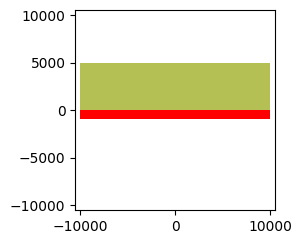

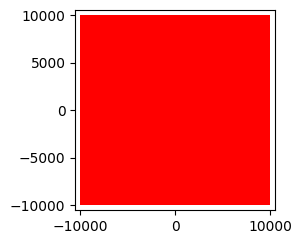

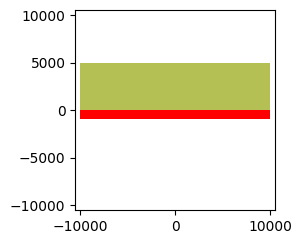

In [38]:
#ground surface
air_surface = openmc.model.RectangularParallelepiped(-10000, 10000, -10000, 10000, 0, 5000)
air_cell = openmc.Cell(region=-air_surface, fill=air)

ground_surface = openmc.model.RectangularParallelepiped(-10000, 10000, -10000, 10000, -1000, 0)
ground_cell = openmc.Cell(region=-ground_surface, fill=ground_material)

xmin = openmc.XPlane(x0=-10001, boundary_type = 'vacuum')
xmax = openmc.XPlane(x0=10001, boundary_type = 'vacuum')
ymin = openmc.YPlane(y0=-10001, boundary_type = 'vacuum')
ymax = openmc.YPlane(y0=10001, boundary_type = 'vacuum')
zmin = openmc.ZPlane(z0=-1001, boundary_type = 'vacuum')
zmax = openmc.ZPlane(z0=5001, boundary_type = 'vacuum')

void_region = +xmin & -xmax & -ymax & +ymin & +zmin & -zmax

void_cell =  openmc.Cell(region=void_region)

universe = openmc.Universe(cells=[air_cell, void_cell, ground_cell])
geom = openmc.Geometry(universe)
geom.export_to_xml()
color_assignment = {void_cell: 'blue', ground_cell: 'red', air:'purple'}
plt.show(universe.plot(width=(21100, 21100), basis='xz', colors=color_assignment))
plt.show(universe.plot(width=(21100, 21100), basis='xy', colors=color_assignment))
plt.show(universe.plot(width=(21100, 21100), basis='yz', colors=color_assignment))



In [52]:
from math import cos, pi
#create the source
sett = openmc.Settings()
sett.particles = 10000000
sett.batches = 5
sett.inactive = 0
sett.run_mode = 'fixed source'

source = openmc.Source()
source.particle = 'neutron'
source.energy = openmc.stats.Discrete([1e5], [1])

theta = np.arctan(10000/4000)
mu = openmc.stats.Uniform(cos(theta), 1.0)
phi = openmc.stats.Uniform(0.0, 2*pi)
source.angle  = openmc.stats.PolarAzimuthal(mu, phi, reference_uvw=(0, 0., 1))
source.space = openmc.stats.Point((0,0,1000))
sett.source = source

In [53]:
#mesh
air_mesh = openmc.RegularMesh(mesh_id=1, name="air_mesh")
air_mesh.dimension = [60,1,1]
air_mesh.lower_left = [-10000,-10000, 0]
air_mesh.upper_right = [10000,10000, 100]
mesh_filter = openmc.MeshFilter(air_mesh)

/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another MeshBase instance already exists with id=1.
  warn(msg, IDWarning)


In [54]:
#tally

tallies = openmc.Tallies()
shine_tally = openmc.Tally(name='shine_tally')
neutron_filter = openmc.ParticleFilter(['neutron'])
shine_tally.scores  = ['flux']
shine_tally.filters = [mesh_filter, neutron_filter]
tallies.append(shine_tally)

In [55]:
model = openmc.model.Model(geom, mats, sett, tallies)
!rm *.h5
results_filename = model.run()
results = openmc.StatePoint(results_filename)

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [56]:
flux_tally = results.get_tally(name="shine_tally")
df = flux_tally.get_pandas_dataframe()
df

mesh 1       particle nuclide score     mean std. dev.
        x  y  z                                          
0       1  1  1  neutron   total  flux 1.48e-01  5.75e-04
1       2  1  1  neutron   total  flux 1.71e-01  1.43e-03
2       3  1  1  neutron   total  flux 1.96e-01  1.28e-03
3       4  1  1  neutron   total  flux 2.21e-01  1.89e-03
4       5  1  1  neutron   total  flux 2.48e-01  7.44e-04
5       6  1  1  neutron   total  flux 2.76e-01  1.36e-03
6       7  1  1  neutron   total  flux 3.10e-01  1.47e-03
7       8  1  1  neutron   total  flux 3.44e-01  1.48e-03
8       9  1  1  neutron   total  flux 3.79e-01  1.45e-03
9      10  1  1  neutron   total  flux 4.18e-01  1.94e-03
10     11  1  1  neutron   total  flux 4.65e-01  5.72e-04
11     12  1  1  neutron   total  flux 5.14e-01  2.00e-03
12     13  1  1  neutron   total  flux 5.67e-01  1.50e-03
13     14  1  1  neutron   total  flux 6.25e-01  1.68e-03
14     15  1  1  neutron   total  flux 6.89e-01  1.51e-03
15     16  1  1  neutron   total  flux 7.62e-01  8.28e-04
16     17  1  1  neutron   total  flux 8.41e-01  1.31e-03
17     18  1  1  neutron   total  flux 9.25e-01  2.82e-03
18     19  1  1  neutron   total  flux 1.02e+00  9.99e-04
19     20  1  1  neutron   total  flux 1.13e+00  1.12e-03
20     21  1  1  neutron   total  flux 1.24e+00  2.25e-03
21     22  1  1  neutron   total  flux 1.37e+00  3.49e-03
22     23  1  1  neutron   total  flux 1.51e+00  2.47e-03
23     24  1  1  neutron   total  flux 1.66e+00  1.66e-03
24     25  1  1  neutron   total  flux 1.82e+00  3.14e-03
25     26  1  1  neutron   total  flux 2.00e+00  3.10e-03
26     27  1  1  neutron   total  flux 2.18e+00  3.02e-03
27     28  1  1  neutron   total  flux 2.35e+00  2.24e-03
28     29  1  1  neutron   total  flux 2.50e+00  2.61e-03
29     30  1  1  neutron   total  flux 2.60e+00  3.26e-03
30     31  1  1  neutron   total  flux 2.60e+00  3.70e-03
31     32  1  1  neutron   total  flux 2.51e+00  8.35e-04
32     33  1  1  neutron   total  flux 2.36e+00  2.81e-03
33     34  1  1  neutron   total  flux 2.18e+00  4.05e-03
34     35  1  1  neutron   total  flux 1.99e+00  2.94e-03
35     36  1  1  neutron   total  flux 1.82e+00  2.68e-03
36     37  1  1  neutron   total  flux 1.66e+00  2.21e-03
37     38  1  1  neutron   total  flux 1.51e+00  2.32e-03
38     39  1  1  neutron   total  flux 1.37e+00  2.75e-03
39     40  1  1  neutron   total  flux 1.24e+00  2.80e-03
40     41  1  1  neutron   total  flux 1.12e+00  2.51e-03
41     42  1  1  neutron   total  flux 1.02e+00  2.49e-03
42     43  1  1  neutron   total  flux 9.27e-01  2.69e-03
43     44  1  1  neutron   total  flux 8.43e-01  1.33e-03
44     45  1  1  neutron   total  flux 7.65e-01  1.54e-03
45     46  1  1  neutron   total  flux 6.94e-01  2.63e-03
46     47  1  1  neutron   total  flux 6.29e-01  1.69e-03
47     48  1  1  neutron   total  flux 5.73e-01  1.51e-03
48     49  1  1  neutron   total  flux 5.13e-01  9.57e-04
49     50  1  1  neutron   total  flux 4.66e-01  4.56e-04
50     51  1  1  neutron   total  flux 4.21e-01  7.37e-04
51     52  1  1  neutron   total  flux 3.83e-01  1.37e-03
52     53  1  1  neutron   total  flux 3.44e-01  9.80e-04
53     54  1  1  neutron   total  flux 3.09e-01  5.96e-04
54     55  1  1  neutron   total  flux 2.76e-01  1.13e-03
55     56  1  1  neutron   total  flux 2.48e-01  2.22e-03
56     57  1  1  neutron   total  flux 2.21e-01  8.91e-04
57     58  1  1  neutron   total  flux 1.95e-01  7.39e-04
58     59  1  1  neutron   total  flux 1.69e-01  7.73e-04
59     60  1  1  neutron   total  flux 1.47e-01  6.41e-04

In [57]:
distance_x = air_mesh.vertices[:,0,0,0]
distance_x


array([-10000.        ,  -9666.66666667,  -9333.33333333,  -9000.        ,
        -8666.66666667,  -8333.33333333,  -8000.        ,  -7666.66666667,
        -7333.33333333,  -7000.        ,  -6666.66666667,  -6333.33333333,
        -6000.        ,  -5666.66666667,  -5333.33333333,  -5000.        ,
        -4666.66666667,  -4333.33333333,  -4000.        ,  -3666.66666667,
        -3333.33333333,  -3000.        ,  -2666.66666667,  -2333.33333333,
        -2000.        ,  -1666.66666667,  -1333.33333333,  -1000.        ,
         -666.66666667,   -333.33333333,      0.        ,    333.33333333,
          666.66666667,   1000.        ,   1333.33333333,   1666.66666667,
         2000.        ,   2333.33333333,   2666.66666667,   3000.        ,
         3333.33333333,   3666.66666667,   4000.        ,   4333.33333333,
         4666.66666667,   5000.        ,   5333.33333333,   5666.66666667,
         6000.        ,   6333.33333333,   6666.66666667,   7000.        ,
         7333.33333333,  

In [60]:
air_mesh.vertices

array([[[[-10000.        , -10000.        ,      0.        ],
         [-10000.        , -10000.        ,    100.        ]],

        [[-10000.        ,  10000.        ,      0.        ],
         [-10000.        ,  10000.        ,    100.        ]]],


       [[[ -9666.66666667, -10000.        ,      0.        ],
         [ -9666.66666667, -10000.        ,    100.        ]],

        [[ -9666.66666667,  10000.        ,      0.        ],
         [ -9666.66666667,  10000.        ,    100.        ]]],


       [[[ -9333.33333333, -10000.        ,      0.        ],
         [ -9333.33333333, -10000.        ,    100.        ]],

        [[ -9333.33333333,  10000.        ,      0.        ],
         [ -9333.33333333,  10000.        ,    100.        ]]],


       [[[ -9000.        , -10000.        ,      0.        ],
         [ -9000.        , -10000.        ,    100.        ]],

        [[ -9000.        ,  10000.        ,      0.        ],
         [ -9000.        ,  10000.        ,    100

In [58]:
flux = df[df['score'] == 'flux']
flux = flux["mean"]
flux

0     0.147910
1     0.170913
2     0.196207
3     0.220542
4     0.248076
5     0.276367
6     0.309692
7     0.343563
8     0.379360
9     0.418369
10    0.465258
11    0.513932
12    0.566937
13    0.624674
14    0.689476
15    0.762450
16    0.841194
17    0.924691
18    1.021018
19    1.127469
20    1.242670
21    1.367625
22    1.505967
23    1.657408
24    1.823145
25    1.997390
26    2.178114
27    2.349572
28    2.502225
29    2.599286
30    2.598048
31    2.507217
32    2.359327
33    2.181961
34    1.994586
35    1.823552
36    1.656941
37    1.511173
38    1.366062
39    1.238112
40    1.123255
41    1.021985
42    0.926946
43    0.843333
44    0.765473
45    0.694035
46    0.629058
47    0.572564
48    0.513088
49    0.466311
50    0.420737
51    0.382674
52    0.344000
53    0.309080
54    0.276072
55    0.248254
56    0.220564
57    0.195203
58    0.169292
59    0.147276
Name: mean, dtype: float64

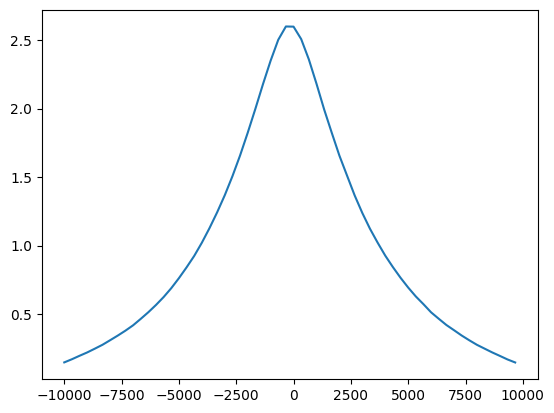

In [59]:
plt.plot(distance_x[:-1], flux)